# H12 signal detection

In [1]:
# Notebook parameters. Values here are for development only and 
# will be overridden when running via snakemake and papermill.
# cohort_id = 'CD-NU_Gbadolite_gamb_2015_Q3'
cohort_id = 'llineup'
#cohorts_analysis = "20230223"
contig = '3RL'
sample_sets = ["1288-VO-UG-DONNELLY-VMF00168","1288-VO-UG-DONNELLY-VMF00219"]
sample_query = "aim_species == 'gambiae' & sex_call == 'F'"
min_cohort_size = None
max_cohort_size = None
use_gcs_cache = False
dask_scheduler = "threads"
h12_signal_detection_min_delta_aic = 1000
h12_signal_detection_min_stat_max = 0.1
h12_signal_detection_gflanks = [6]

## Setup

In [3]:
import yaml
import pandas as pd
import malariagen_data
from pyprojroot import here
import numpy as np
import os
import dask
dask.config.set(scheduler=dask_scheduler);
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import lmfit
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run peak-utils.ipynb

In [7]:
ag3 = malariagen_data.Ag3(pre = True)

In [4]:
# load window sizes from output of h12-calibration
#calibration_dir = "./scripts_notebooks/haplotype_clustering/peak_centre"
calibration_file_path = f"{cohort_id}.yaml"
with open(calibration_file_path, 'r') as calibration_file:
    calibration_params = yaml.safe_load(calibration_file)
window_size = calibration_params["h12_window_size"]
window_size

1000

## Run signal detection

In [5]:
# set parameters for signal detection
filter_size = 20  # hampel filter parameter
filter_t = 2  # hampel filter parameter
scan_interval = 1  # step in cM
min_baseline = 0
max_baseline_percentile = 95
min_amplitude = 0.03
init_amplitude = 0.5
max_amplitude = 1.5
min_decay = 0.1
init_decay = 0.5 
max_abs_skew = 0.5
scan_start = None
scan_stop = None
# TODO maybe set false in production to avoid too many plots?
debug = True

In [8]:
# load gwss data
ppos, h12, x= ag3.h12_gwss(
    contig=contig, 
    window_size=window_size, 
    analysis='gamb_colu', 
    sample_sets=sample_sets,
    sample_query=sample_query, 
    min_cohort_size=min_cohort_size,
    max_cohort_size=max_cohort_size,
)

Load haplotypes:   0%|          | 0/3672 [00:00<?, ?it/s]

In [9]:
# convert to int
ppos = ppos.astype(int)

In [10]:
# map physical to genetic position
gpos = ag_p2g(contig=contig, ppos=ppos)

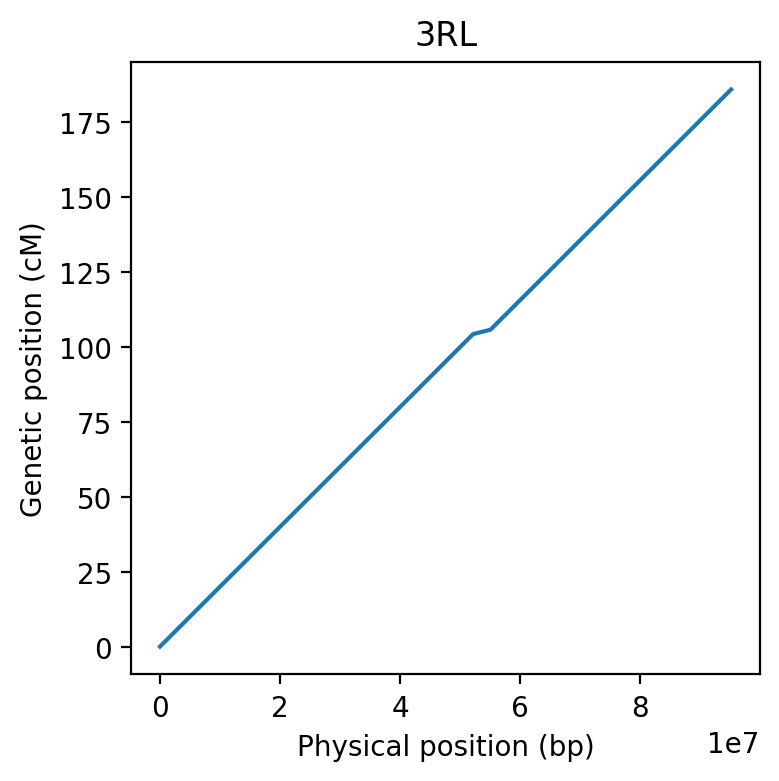

In [11]:
if debug:
    # quick check of genetic map
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ppos, gpos)
    ax.set_xlabel('Physical position (bp)')
    ax.set_ylabel('Genetic position (cM)')
    ax.set_title(contig)
    fig.tight_layout()


In [12]:
# filter outliers
h12_filtered = hampel_filter(h12, size=filter_size, t=filter_t)

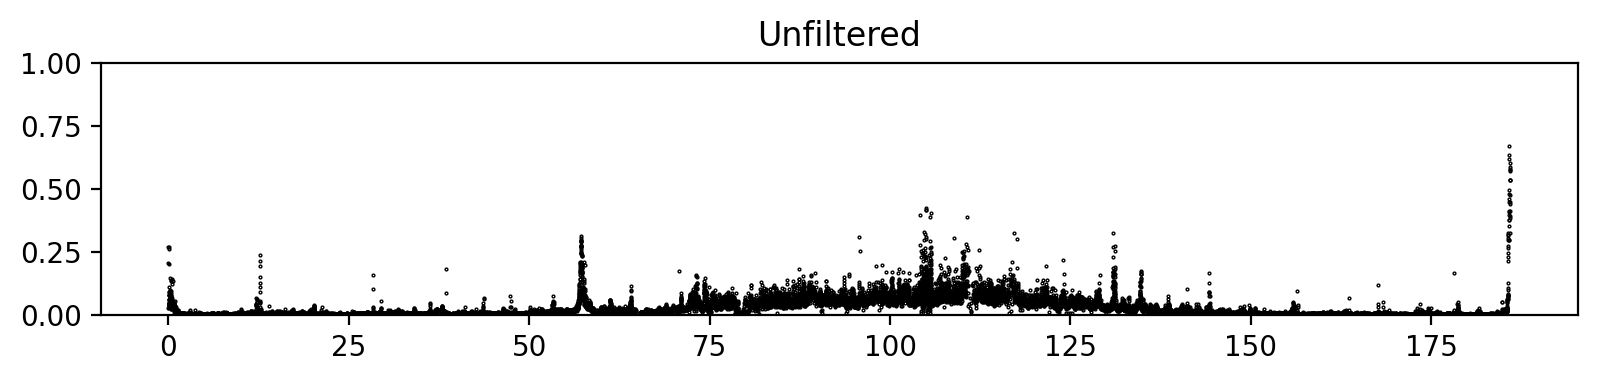

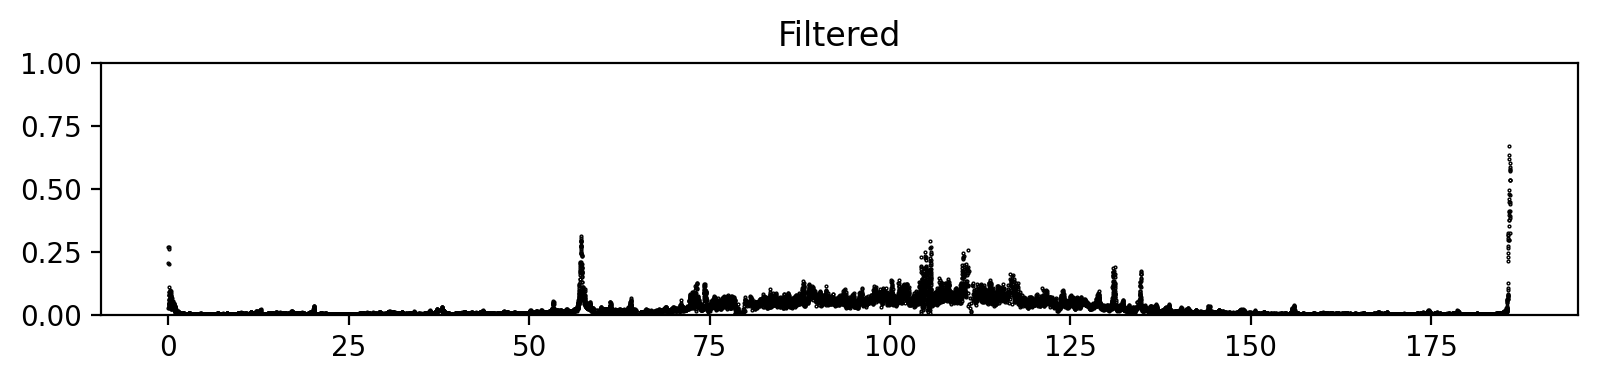

In [13]:
if debug:

    # before filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Unfiltered')
    ax.set_ylim(0, 1)
    fig.tight_layout()

    # after filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12_filtered, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Filtered')
    ax.set_ylim(0, 1)
    fig.tight_layout()


In [14]:
# set parameters
init_baseline = np.median(h12_filtered)
max_baseline = np.percentile(h12_filtered, max_baseline_percentile)
min_skew, init_skew, max_skew = -max_abs_skew, 0, max_abs_skew
if not scan_start:
    scan_start = 2
if not scan_stop:
    scan_stop = gpos[-1] - 2

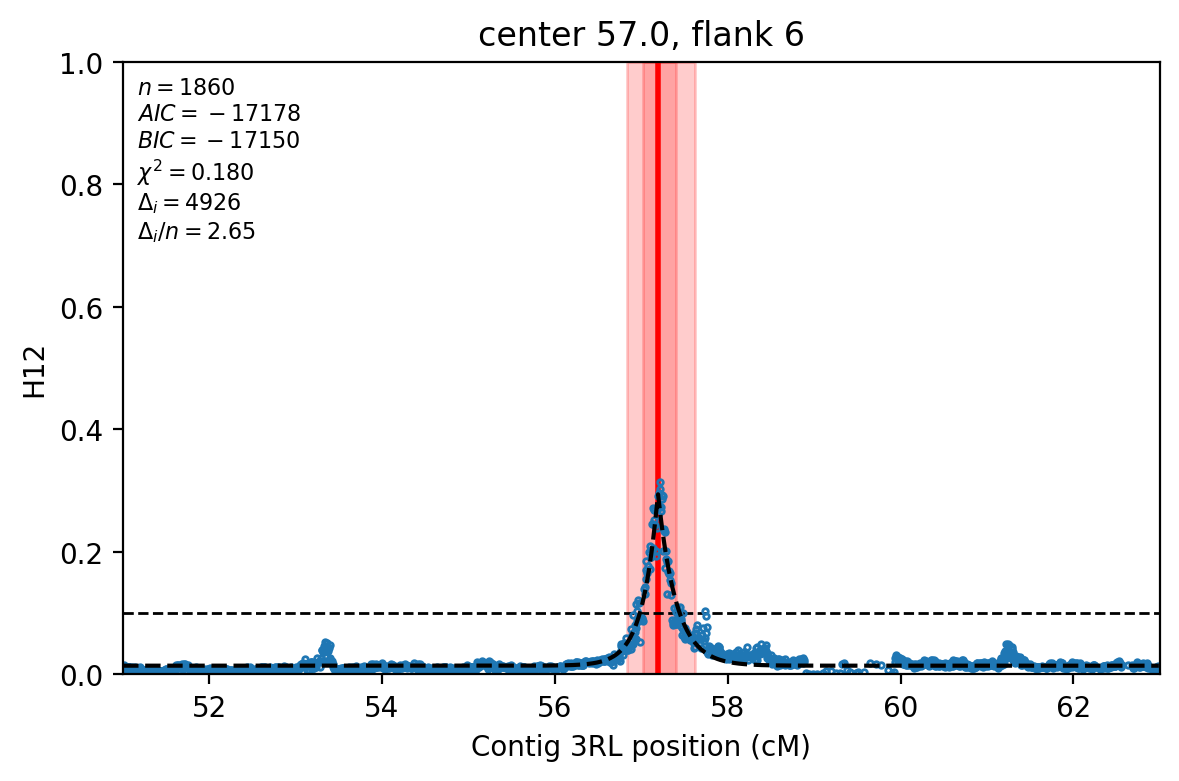

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 1860
    # variables        = 5
    chi-square         = 0.18045115
    reduced chi-square = 9.7278e-05
    Akaike info crit   = -17177.5661
    Bayesian info crit = -17149.9244
    R-squared          = 0.92952211
[[Variables]]
    center:     57.1925635 +/- 0.00167307 (0.00%) (init = 57)
    amplitude:  0.28176026 +/- 0.00243329 (0.86%) (init = 0.5)
    decay:      0.19334083 +/- 0.00247705 (1.28%) (init = 0.5)
    skew:      -0.13342574 +/- 0.01780799 (13.35%) (init = 0)
    baseline:   0.01428957 +/- 2.4603e-04 (1.72%) (init = 0.007077158)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = +0.6989
    C(amplitude, decay) = -0.6693
    C(decay, baseline)  = -0.2680
    C(decay, skew)      = +0.1067


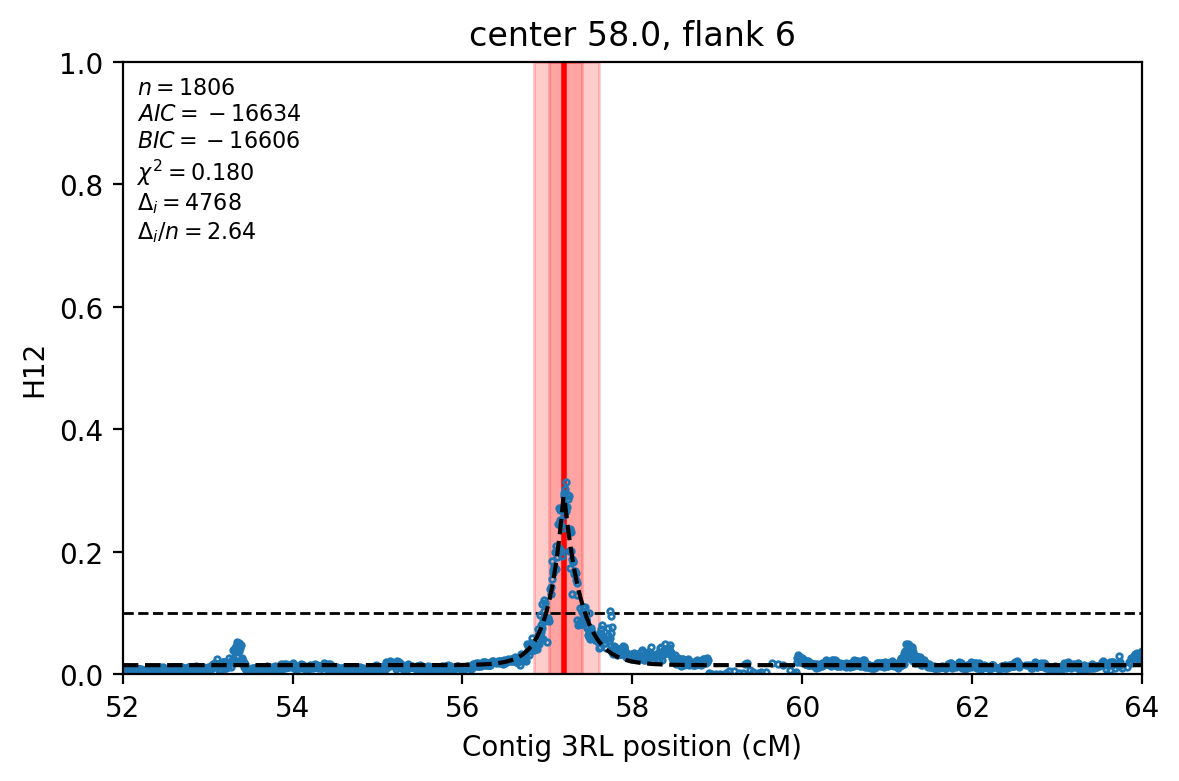

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 1806
    # variables        = 5
    chi-square         = 0.17959957
    reduced chi-square = 9.9722e-05
    Akaike info crit   = -16633.9068
    Bayesian info crit = -16606.4125
    R-squared          = 0.92896770
[[Variables]]
    center:     57.1928609 +/- 0.00168104 (0.00%) (init = 58)
    amplitude:  0.28205962 +/- 0.00248109 (0.88%) (init = 0.5)
    decay:      0.19062972 +/- 0.00248971 (1.31%) (init = 0.5)
    skew:      -0.12890474 +/- 0.01814082 (14.07%) (init = 0)
    baseline:   0.01514469 +/- 2.5311e-04 (1.67%) (init = 0.007077158)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = +0.6990
    C(amplitude, decay) = -0.6691
    C(decay, baseline)  = -0.2704
    C(decay, skew)      = +0.1070


,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,llineup,3RL,57.192564,28596282,4925,0.313292,57.217872,28608936,57.183750,57.203167,...,0.28176,0.193341,-0.133426,0.176262,0.212075,0.014290,-17177.566105,-17149.924446,0.180451,-12251.997535
1,llineup,3RL,57.192861,28596431,4768,0.313292,57.217872,28608936,57.184144,57.203283,...,0.28206,0.190630,-0.128905,0.174336,0.208447,0.015145,-16633.906835,-16606.412487,0.179600,-11865.722004


In [15]:
# set up results
results = []

# main loop, iterate along the genome
for gcenter in np.arange(scan_start, scan_stop, scan_interval):

    for gflank in h12_signal_detection_gflanks:

        # print('center', gcenter, 'flank size', gflank)

        result = fit_exponential_peak(
            ppos=ppos, 
            gpos=gpos, 
            stat_filtered=h12_filtered, 
            gcenter=gcenter, 
            gflank=gflank, 
            scan_interval=scan_interval,
            init_amplitude=init_amplitude,
            min_amplitude=min_amplitude,
            max_amplitude=max_amplitude,
            init_decay=init_decay,
            min_decay=min_decay,
            init_skew=init_skew,
            min_skew=min_skew,
            max_skew=max_skew,
            init_baseline=init_baseline,
            min_baseline=min_baseline,
            max_baseline=max_baseline,
            min_delta_aic=h12_signal_detection_min_delta_aic,
            min_stat_max=h12_signal_detection_min_stat_max,
            debug=debug,
        )

        if result is not None:
            results.append(result)

df_signals = pd.DataFrame.from_records(results)
df_signals

In [30]:
def dedup_signals(df_signals):
    
    keep = list(range(len(df_signals)))
    for i, this in df_signals.iterrows():
        for j, that in df_signals.iterrows():
            if i != j:
                # thank you Ned Batchelder
                # https://nedbatchelder.com/blog/201310/range_overlap_in_two_compares.html
                disjoint = that.span1_gstart > this.span1_gstop or that.span1_gstop < this.span1_gstart
                if not disjoint and that.delta_i > this.delta_i:
                    keep.remove(i)
                    break
    return df_signals.iloc[keep].copy()


In [31]:
df_signals_dedup = dedup_signals(df_signals)
df_signals_dedup

,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,llineup,3RL,57.192564,28596282,4925,0.313292,57.217872,28608936,57.18375,57.203167,...,0.28176,0.193341,-0.133426,0.176262,0.212075,0.01429,-17177.566105,-17149.924446,0.180451,-12251.997535


## Write outputs

In [ ]:
outdir= "./scripts_notebooks/haplotype_clustering/peak_centre"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir, f"{cohort_id}_{contig}.csv"), mode="w") as output_file:
    df_signals_dedup.to_csv(output_file, index=False)